In [1]:
# Correct the camera distortion

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

# Function to undistort the image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera and cv2.undistort()
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

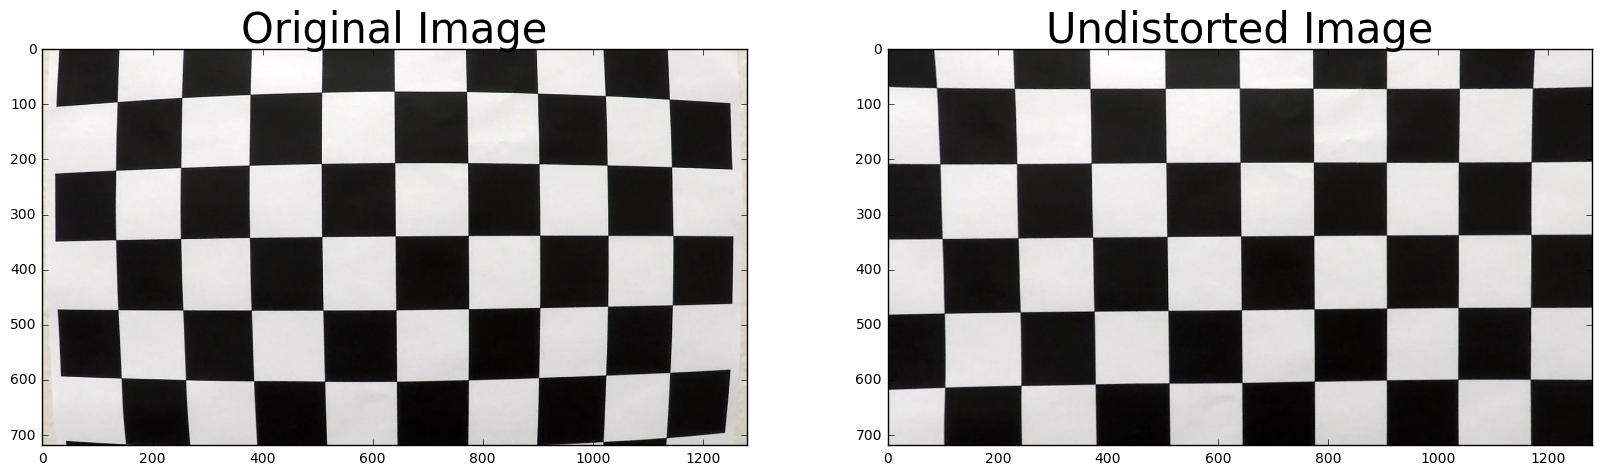

In [2]:
# Test undistort some test image
img = mpimg.imread('camera_cal/calibration1.jpg')
img_undis = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undis)
ax2.set_title('Undistorted Image', fontsize=30)

Image Size:
(960, 540)


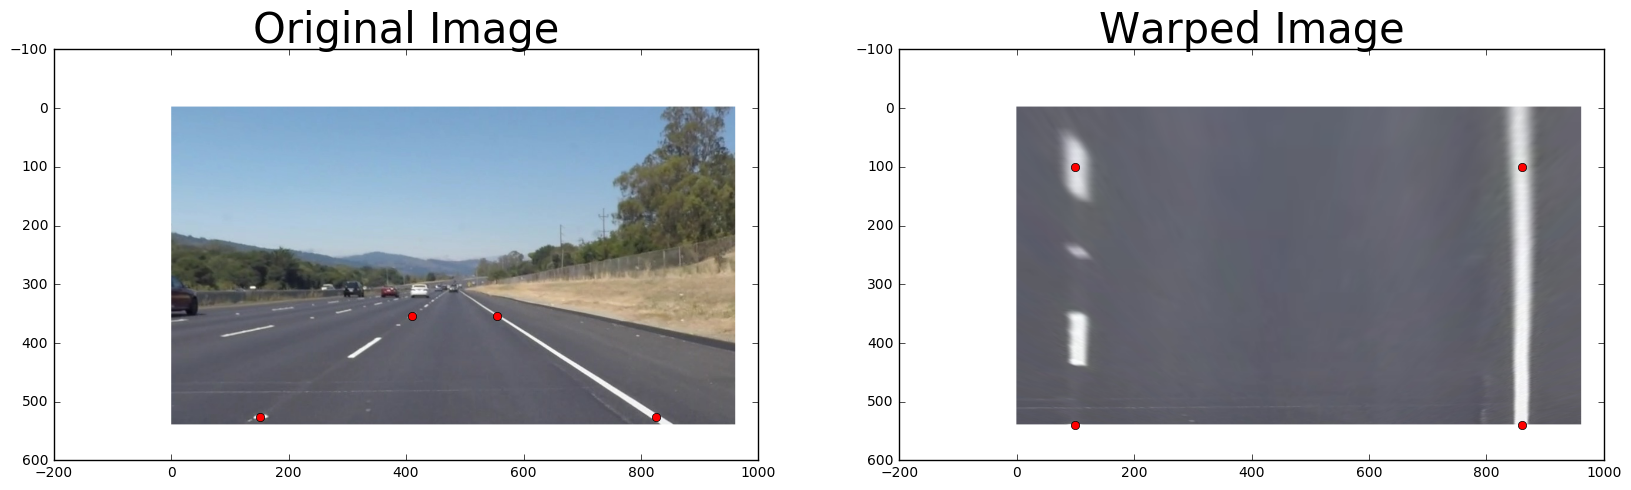

In [3]:
# Perform perspective transform, get transform matrix M
%matplotlib inline
img = mpimg.imread('test_images/solidWhiteRight.jpg')
img_undist = cal_undistort(img, objpoints, imgpoints)
img_size = (img_undist.shape[1], img_undist.shape[0])
print ('Image Size:')
print (img_size)

# Find 4 corner points on the two straight lanes
# (152,526)(825,526)(410,354)(555,354)

offset = 100
src = np.float32([[410,354], [555,354], [825,526], [152,526]])
dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]], 
                                     [offset, img_size[1]]])

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(img_undist, M, img_size)

# Plot the original image and transformed image with four corner points
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_undist)
ax1.plot([152,825,410,555],[526,526,354,354],'ro')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.plot([100,860,860,100],[100,100,540,540],'ro')
ax2.set_title('Warped Image', fontsize=30)

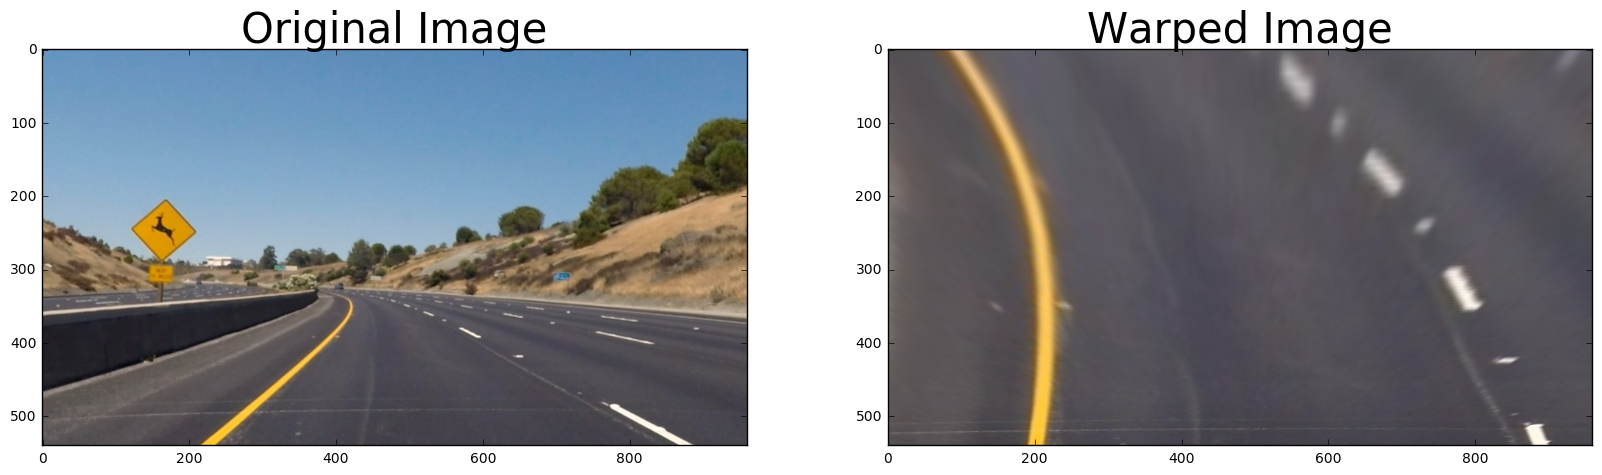

In [6]:
# Define perspective transform function

def pespective_transform(img, M):
    img_size = (960, 540)
    img_resize = cv2.resize(img, img_size) 
    warped = cv2.warpPerspective(img_resize, M, img_size)
    return warped

# Test transforming a curved image

test_img = mpimg.imread('test_images/test2.jpg')
test_img_undist = cal_undistort(test_img, objpoints, imgpoints)
test_img_warped = pespective_transform(test_img_undist, M)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.resize(test_img_undist, (960, 540)) )
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_img_warped)
ax2.set_title('Warped Image', fontsize=30)


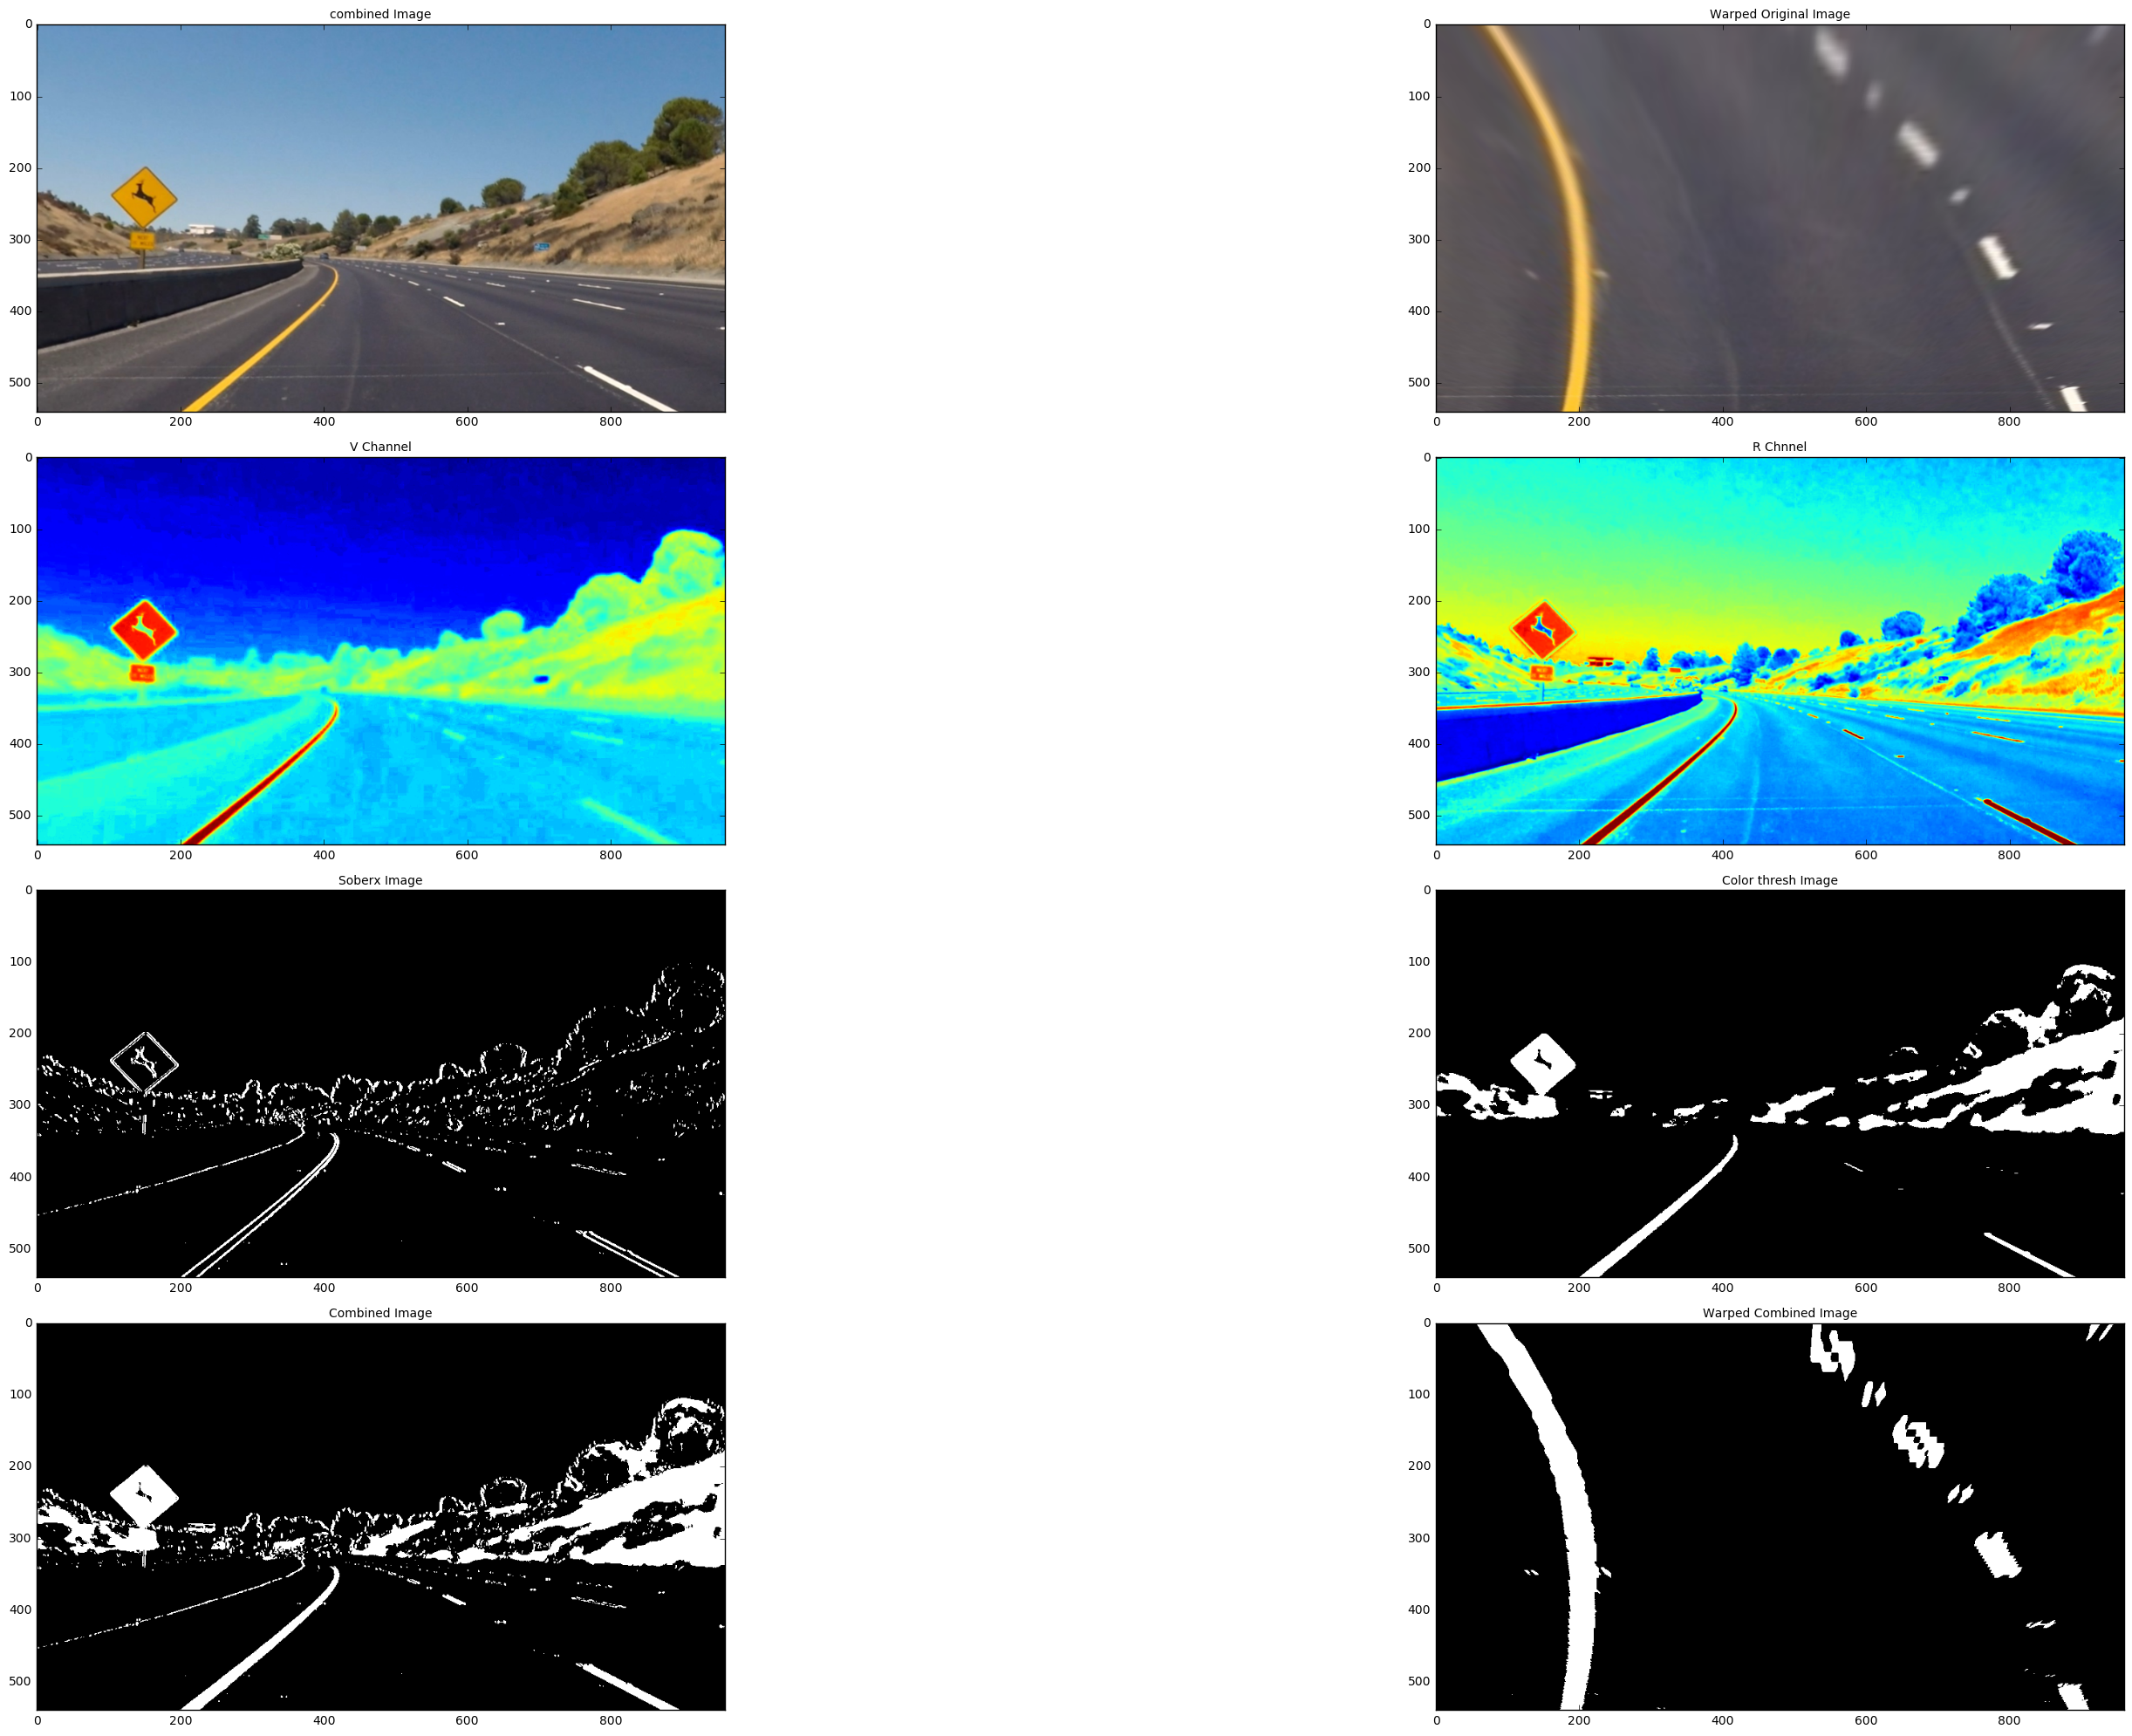

In [67]:
# Thresholding for gradient and color

# Threshold for 
def abs_sobel_thresh(img, orient='x', sobel_kernel=1, thresh=(20,100)):
#    warped_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#    h_channel = warped_hls[:,:,0]
#    l_channel = warped_hls[:,:,1]
#    s_channel = warped_hls[:,:,2]
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Threshold for magnitude
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Threshold for direction
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

# Threshold for direction
def color_threshold(img, r_thresh=(150, 255), v_thresh=(150, 255)):
    r_channel = img[:,:,0]    
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
    v_channel = luv[:,:,2]
    
    v_binary_output = np.zeros_like(v_channel)
    r_binary_output = np.zeros_like(r_channel)
    binary_output = np.zeros_like(r_channel)
    
    v_binary_output[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    r_binary_output[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    binary_output[(v_binary_output == 1) | (r_binary_output == 1)] = 1
    return binary_output, v_channel, r_channel

test_img = mpimg.imread('test_images/test2.jpg')
test_img = cv2.resize(test_img, (960, 540))
test_img = cal_undistort(test_img, objpoints, imgpoints)

sr_binary, v_channel, r_channel = color_threshold(test_img, r_thresh=(230, 255), v_thresh=(160, 255))
gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
sxbinary = abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(40,255))

combined = np.zeros_like(sxbinary)
combined[(sxbinary == 1) | (sr_binary == 1)] = 1

combined_warped = pespective_transform(combined, M)
test_img_warped = pespective_transform(test_img, M)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8) ) = plt.subplots(4, 2, figsize=(40,20))

ax1.imshow(test_img)
ax1.set_title('combined Image', fontsize=10)
ax2.imshow(test_img_warped)
ax2.set_title('Warped Original Image', fontsize=10)

ax3.imshow(v_channel)
ax3.set_title('V Channel', fontsize=10)
ax4.imshow(r_channel)
ax4.set_title('R Chnnel', fontsize=10)

ax5.imshow(sxbinary, cmap='gray')
ax5.set_title('Soberx Image', fontsize=10)
ax6.imshow(sr_binary, cmap='gray')
ax6.set_title('Color thresh Image', fontsize=10)

ax7.imshow(combined, cmap='gray')
ax7.set_title('Combined Image', fontsize=10)
ax8.imshow(combined_warped, cmap='gray')
ax8.set_title('Warped Combined Image', fontsize=10)

plt.tight_layout()

188 782


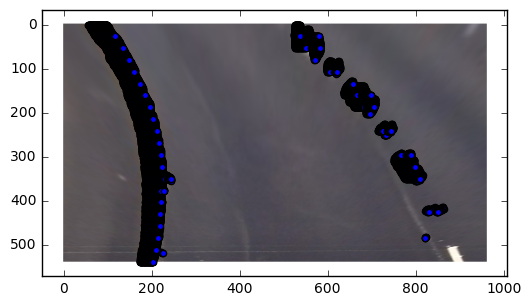

In [68]:
# Finding the lines
img = combined_warped

#  Function to find the initial lane position at the bottom
def lane_init(img):
    histogram = np.mean(img[img.shape[0]//2:,:], axis=0)
    left_init = np.argmax(histogram[:img.shape[1]//3])
    right_init = np.argmax(histogram[img.shape[1]//3*2:]) + int(img.shape[1]//3*2)
    return left_init, right_init

# Use sliding window to find all the lane points
def histogram_lane_detection(img, left_init, right_init, num_bands = 50, lane_width = 0.1):
    
    width = img.shape[1]
    height = img.shape[0]
    band_height = int(1./num_bands * height)   # Divide image into horizontal bands
    band_width = int(lane_width * img.shape[1])
  
    l_x, l_y, r_x, r_y = [], [], [], []
    
    left_pre = left_init
    right_pre = right_init
    
    for i in reversed(range(num_bands)):
        
        w_left = img[i*band_height:(i+1)*band_height,left_pre-band_width//2:left_pre+band_width//2]
        w_right = img[i*band_height:(i+1)*band_height,right_pre-band_width//2:right_pre+band_width//2]
        
        left_y_pt, left_x_pt = np.nonzero(w_left)
        right_y_pt, right_x_pt = np.nonzero(w_right)
        
        l_x.extend(left_x_pt + left_pre-band_width//2)
        l_y.extend(left_y_pt + i*band_height)
        r_x.extend(right_x_pt+ right_pre-band_width//2)
        r_y.extend(right_y_pt+ i*band_height)

        # Find 'x' with mean of nonzero elements as baseline for next window
        s_left = np.sum(w_left, axis=0)
        s_right = np.sum(w_right, axis=0)
        
        if np.any(s_left > 0):
            a = np.argwhere(s_left>0)
            left_pre = np.mean(a) + left_pre - band_width//2
        if np.any(s_right > 0):
            a = np.argwhere(s_right>0)
            right_pre = np.mean(a) + right_pre - band_width//2
    
    l_x = np.array(l_x)
    l_y = np.array(l_y)
    r_x = np.array(r_x)
    r_y = np.array(r_y)
    
    return l_x, l_y, r_x, r_y

# Test on a image

left_init, right_init = lane_init(img)
print (left_init, right_init)

l_x, l_y, r_x, r_y = histogram_lane_detection(img, left_init, right_init, num_bands = 20, lane_width = 0.1)
plt.imshow(test_img_warped)
plt.scatter(l_x,l_y)
plt.scatter(r_x,r_y)


5033.44 m 3242.49 m
-0.27


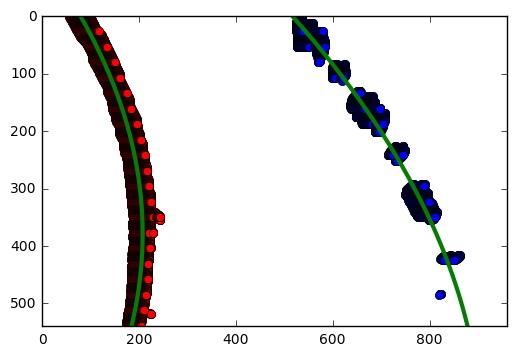

In [69]:
# Fit the both lanes

def fit_lanes(img, l_x,l_y,r_x,r_y):
    # Fit a second order polynomial to each fake lane line
    left_fit = np.polyfit(l_y, l_x, 2)
    right_fit = np.polyfit(r_y, r_x, 2)
    
    y_spacing = np.linspace(0.0, 539.0, num=540)
    left_fitx = left_fit[0]*y_spacing**2 + left_fit[1]*y_spacing + left_fit[2]
    right_fitx = right_fit[0]*y_spacing**2 + right_fit[1]*y_spacing+ right_fit[2]
    
    #Caculate the curvature
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension

    left_fit_cr = np.polyfit(l_y*ym_per_pix, l_x*xm_per_pix, 2)
    right_fit_cr = np.polyfit(r_y*ym_per_pix, r_x*xm_per_pix, 2)
        
    y_eval = np.max(y_spacing)
    
    l_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
    r_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
        
    l_curverad = round(l_curverad,2)
    r_curverad = round(r_curverad,2)
    
    
    # meters from center
    screen_middel_pixel = img.shape[1]/2
    left_lane_pixel = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]    # x position for left lane
    right_lane_pixel = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]   # x position for right lane
    car_middle_pixel = int((right_lane_pixel + left_lane_pixel)/2)
    screen_off_center = screen_middel_pixel-car_middle_pixel
    meters_off_center = xm_per_pix * screen_off_center   
    meters_off_center = round(meters_off_center,3)
    
    return y_spacing, left_fitx, right_fitx, l_curverad, r_curverad, meters_off_center

y_spacing, left_fitx, right_fitx, l_curverad, r_curverad, meters_off_center = fit_lanes(img, l_x,l_y,r_x,r_y)


plt.plot(l_x, l_y, 'o', color='red')
plt.plot(r_x, r_y, 'o', color='blue')
plt.xlim(0, 960)
plt.ylim(0, 540)
plt.plot(left_fitx, y_spacing, color='green', linewidth=3)
plt.plot(right_fitx, y_spacing, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

print ("%0.2f" %l_curverad,'m', "%0.2f" %r_curverad,'m',)
test = str(l_curverad) + 'm' + '\n' + str( r_curverad) + 'm'
print (meters_off_center)

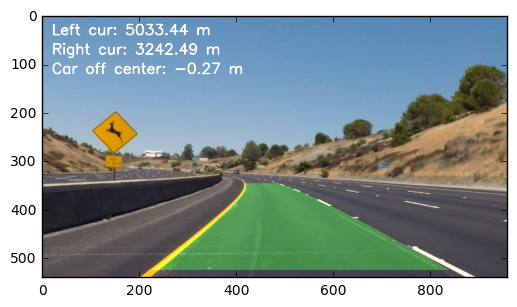

In [70]:
# Draw on the origal image

# Create an image to draw the lines on
def draw_lanes(img, y_spacing, left_fitx, right_fitx,l_curverad, r_curverad, meters_off_center):

    warp_zero = np.zeros_like(combined_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, y_spacing]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, y_spacing])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    l_curverad = 'Left cur: '+ str(l_curverad) + ' m' 
    r_curverad = 'Right cur: ' + str(r_curverad) + ' m'
    off_center = 'Car off center: ' + str(meters_off_center) + ' m'
    
    result = cv2.putText(result,l_curverad,(20,40), font, 1, (255,255,255), 2, cv2.LINE_AA)
    result = cv2.putText(result,r_curverad,(20,80), font, 1, (255,255,255), 2, cv2.LINE_AA)
    result = cv2.putText(result,off_center,(20,120), font, 1, (255,255,255), 2, cv2.LINE_AA)
    
    return result
    
result=draw_lanes(test_img, y_spacing, left_fitx, right_fitx,l_curverad, r_curverad,meters_off_center)

plt.imshow(result)



In [54]:
# Creat a pipline to detect lane from raw image to final stage
def advanced_lane_dectection(img):
    img_shape = (img.shape[1], img.shape[0])     
    img_resize = cv2.resize(img, (960, 540))
    img_undis = cal_undistort(img_resize, objpoints, imgpoints)
    
    sr_binary, s_channel, r_channel = color_threshold(img_undis, r_thresh=(230, 255), v_thresh=(160, 255))
    gray = cv2.cvtColor(img_undis, cv2.COLOR_RGB2GRAY)
    sxbinary = abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(40,255))

    combined = np.zeros_like(sxbinary)
    combined[(sxbinary == 1) | (sr_binary == 1)] = 1
    
    combined_warped = pespective_transform(combined, M)
    test_img_warped = pespective_transform(img_undis, M)
    
    left_init, right_init = lane_init(combined_warped)
    l_x, l_y, r_x, r_y = histogram_lane_detection(combined_warped, left_init, right_init, num_bands = 20, lane_width = 0.1)
    
    
    y_spacing, left_fitx, right_fitx, l_curverad, r_curverad, meters_off_center = fit_lanes(combined_warped, l_x,l_y,r_x,r_y)
    
    result = draw_lanes(img_undis, y_spacing, left_fitx, right_fitx,l_curverad, r_curverad, meters_off_center)
    
    result_resize = cv2.resize(result, img_shape)
    
    return result_resize

In [55]:
# Test all images
test_img = glob.glob('test_images/test*.jpg')

for idx, fname in enumerate(test_img):
    img = mpimg.imread(fname)
    img_with_lanes =  advanced_lane_dectection(img)
    img_with_lanes = cv2.cvtColor(img_with_lanes, cv2.COLOR_RGB2BGR)
    write_name = 'test_images/'+'lanes_found'+str(idx)+'.jpg'
    cv2.imwrite(write_name, img_with_lanes)

In [57]:
# Test all images
test_img = glob.glob('problem_frames/*.jpg')

for idx, fname in enumerate(test_img):
    img = mpimg.imread(fname)
    img_with_lanes =  advanced_lane_dectection(img)
    img_with_lanes = cv2.cvtColor(img_with_lanes, cv2.COLOR_RGB2BGR)
    write_name = 'problem_frames/'+'lanes_found'+str(idx)+'.jpg'
    cv2.imwrite(write_name, img_with_lanes)

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [58]:
output = 'project_video_lanes.mp4'
clip = VideoFileClip("project_video.mp4")
vid_clip = clip.fl_image(advanced_lane_dectection) #NOTE: this function expects color images!!
%time vid_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_lanes.mp4
[MoviePy] Writing video project_video_lanes.mp4


100%|█████████████████████████████████████████████████████████████▉| 1260/1261 [30:45<00:01,  1.44s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lanes.mp4 

Wall time: 30min 45s


In [71]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))